In [3]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import itertools
from matplotlib.ticker import MultipleLocator
import seaborn as sns

In [4]:
import re

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:
data_path = "/Users/kritiaxh/Documents/PoldrackLab/SharedControl/data/raw/"
exp_stage = "final"
task = "shared_control"

pattern = os.path.join(data_path, exp_stage, '*', task, '*.csv')
data_files = glob.glob(pattern)

In [7]:
def get_subject_label(file):
    """
    Extract the subject label from a given file path.

    Parameters:
    - file (str): The file path from which to extract the subject label.

    Returns:
    - str or None: The extracted subject label (e.g., 's001') if found, 
                   otherwise returns None and prints a message.
    """
    
    match = re.search(r'/sub-(s\d{3})/', file)
    
    if match:
        subject_label = match.group(1)
        print("Subject label:", subject_label)
        return subject_label
    else:
        print("No subject label found.")
        return None

In [8]:
def string_to_numbers(string_data):
    """
    Convert a string of numbers into a list of floats.
    
    Parameters:
    - string_data (str or float): A string containing space-separated numbers or a single float.
    
    Returns:
    - List: A list of floats converted from the input string or a list containing 
      the float if the input is already a float.
    """
    if isinstance(string_data, float):  # Check if the input is already a float
        return [string_data]  # If it's a float, return it as a list
    string_data = string_data.strip("'")  # Remove leading and trailing single quotes
    numbers = [float(num) for num in string_data.split()]
    return numbers

In [9]:
def calculate_intervals(time_stamps, distances_raw, pressures_raw, endpoint, stop_onset, critical_distance=1.2, interval_duration=0.1):
    """
    Calculate accuracies, pressures, and stops at specified intervals until a given endpoint.

    Parameters:
    - time_stamps: Array of timestamps
    - distances_raw: Array of raw distance values
    - pressures_raw: Array of raw pressure values
    - endpoint: The point in time to stop calculations (e.g., stop signal or end of trial)
    - stop_onset: The point in time when the stop signal appears
    - critical_distance: The distance within which the ball is considered 'inside the ring' (default 1.2)
    - interval_duration: The duration of each interval in seconds (default 0.1)

    Returns:
    - accuracies: List of accuracies at each interval
    - pressures: List of average pressures at each interval
    - stops: List indicating whether the stop was present in each interval
    """

    accuracies = []
    pressures = []
    stops = []

    interval_start_idx = 0
    interval_end_time = time_stamps[0] + interval_duration  # Start of the first interval

    while interval_start_idx < len(time_stamps) and time_stamps[interval_start_idx] <= endpoint:
        temp_pressures = []
        inside_ring_count = 0
        count = interval_start_idx  # Tracks the timestamps within the current interval

        # Determine if the stop signal occurs in this interval
        stop = 1 if stop_onset <= interval_end_time else 0

        # Loop through timestamps within the current interval
        while (count < len(time_stamps) and 
               time_stamps[count] <= interval_end_time and 
               time_stamps[count] < endpoint):
            distance = distances_raw[count]
            pressure = pressures_raw[count]

            if abs(distance) <= critical_distance:
                inside_ring_count += 1

            temp_pressures.append(pressure)
            count += 1

        # Calculate accuracy for this interval
        if count > interval_start_idx:  # Avoid division by zero
            go_task_accuracy = inside_ring_count / (count - interval_start_idx)
        else:
            go_task_accuracy = np.nan  # If no data points in this interval

        accuracies.append(go_task_accuracy)

        # Calculate average pressure for this interval
        avg_pressure = np.mean(temp_pressures) if temp_pressures else np.nan
        pressures.append(avg_pressure)

        # Record if stop occurred in this interval
        stops.append(stop)

        # Move to the next interval if the interval start index is not already count (to ensure it doesn't get stuck in an infinite loop)
        if interval_start_idx != count:
            interval_start_idx = count
        else:
            break
        interval_end_time += interval_duration  # Move the interval end time by specified duration

    return accuracies, pressures, stops

In [10]:
def process_trial_data(data, block, min_delay=0.15, threshold_reduction=0.30):
    """
    Process trial data for a specific block, calculating metrics including SSRT,
    moment of inhibition, and pressure measures.

    Parameters:
    - data (DataFrame): A DataFrame containing trial data, including pressure, timestamps, and stop signal data.
    - block (str): The block type (e.g., 'ai', 'non_ai') of the trials to process.
    - min_delay (float): Minimum delay after the stop signal before checking for inhibition (default is 0.15 seconds).
    - threshold_reduction (float): The percentage reduction below which pressure is considered as decreased (default is 30%).

    Returns:
    - trial_results (dict): A dictionary containing various calculated metrics for each trial.
    - ssrt_list (list): A list of SSRT values calculated for each trial.
    """
    trial_results = {}
    ssrt_list = []
    ring_positions_raw = np.arange(-15, 15.0, 0.095).tolist()

    for idx, row in data.iterrows():
        trial_number = idx
        stop_onset = row['SSD_mean']
        time_stamps = row['time_stamps_raw']
        pressures_raw = row['pressures_raw']
        condition = row['condition']
        distances_raw = row['distances_raw']

        # Find the time difference between consecutive time stamps
        differences = []
        for i in range(len(time_stamps) - 1):
            difference = time_stamps[i + 1] - time_stamps[i]
            differences.append(difference)
        average_difference = sum(differences) / len(differences) if differences else 0  
        #print(average_difference)


         # Find the index corresponding to the stop onset time
        if stop_onset is not None:
            stop_onset_idx = next((i for i, t in enumerate(time_stamps) if t >= stop_onset), None)
        else:
            stop_onset_idx = None

        # Calculate the minimum time to start checking for inhibition
        start_check_time = stop_onset + min_delay

        # Find the index where to start checking (first index after the start_check_time)
        index_of_start_check = next((i for i, t in enumerate(time_stamps) if t >= start_check_time), None)

        index_of_inhibition = None
        stop_moment = None
        stop_moment_idx = None
        moment_of_inhibition = None

        # Set metrics that we'll use np.nanmean on later to np.nan
        duration_of_inhibition = np.nan
        distance_at_stop_onset = np.nan
        pressure_at_moment_of_inhibition = np.nan
        distance_at_stop_moment = np.nan
        distance_of_inhibition = np.nan

        # Find the moment of inhibition (first point where pressure reduces by at least 30% monotonically in one of the next five points) 
        # Also, find the pressure at the moment of inhibition.
        if index_of_start_check is not None:
            for i in range(index_of_start_check, len(pressures_raw) - 1):
                current_pressure = pressures_raw[i]
                target_pressure = current_pressure * (1 - threshold_reduction)
                
                # Check if the pressure decreases to below the target
                if pressures_raw[i] > target_pressure:
                    
                    # Check if the next pressures monotonically decrease
                    decreasing = all(pressures_raw[j] <= pressures_raw[j-1] for j in range(i+1, min(i+5, len(pressures_raw))))
                    
                    # Also check if any pressure in the next five is below the target pressure
                    if decreasing and any(pressures_raw[j] <= target_pressure for j in range(i+1, min(i+5, len(pressures_raw)))):
                        moment_of_inhibition = time_stamps[i]
                        index_of_inhibition = i
                        pressure_at_moment_of_inhibition = pressures_raw[i]
                        break
        
        # Find the position at stop onset
        # Ring position at moment of inhibition is the same as ring position at stop onset
        distance_at_stop_onset = distances_raw[stop_onset_idx] + ring_positions_raw[stop_onset_idx]

        # Find the end of inhibition (first zero pressure after the start of inhibition) and distance at the end of inhibition
        if index_of_inhibition is not None:
            stop_moment_indices = [i for i in range(index_of_inhibition, len(pressures_raw)) if pressures_raw[i] == 0]
            if stop_moment_indices:
                stop_moment = time_stamps[stop_moment_indices[0]]
                stop_moment_idx = stop_moment_indices[0]
                # Ring position at stop moment is the same as ring position at stop onset
                distance_at_stop_moment = distances_raw[stop_moment_idx] + ring_positions_raw[stop_onset_idx]

        # Find the duration of inhibition (time between moment of inhibition and end of inhibition) 
        # and distance of inhibition (distance between stop moment and stop onset)
        if moment_of_inhibition is not None and stop_moment is not None:
            duration_of_inhibition = stop_moment - moment_of_inhibition
            distance_of_inhibition = distance_at_stop_moment - distance_at_stop_onset
                
        # Calculate SSRT if both inhibition start and stop moments are identified
        if stop_onset is not None and moment_of_inhibition is not None:
            ssrt = moment_of_inhibition - stop_onset
            ssrt_list.append(ssrt)
        else:
            print(f'Trial {idx} has no SSRT, condition = {condition} // block = {block}')
            ssrt = np.nan
            ssrt_list.append(ssrt)
        
        # Calculate Go Task Measure at the Onset of the Stop Signal 1 - fully within the ring, 0 - outside the ring
        critical_distance = 2 - 0.8 # this should be the distance that needs to be cleared to be outside the circle
        if stop_onset is not None:
            stop_distance = distances_raw[stop_onset_idx]
            if abs(stop_distance) > critical_distance:
                go_task_accuracy_at_stop_onset = 0
            else:
                go_task_accuracy_at_stop_onset = 1
        else:
            stop_distance = np.nan
        
        # Calculate Go Task Accuracy throughout the task until the Stop Signal Appears 1 - within the ring the whole time, 0 - never in the ring
        # Also find the proportion of times the ball was ahead of or behind the ring before the stop onset
        inside_ring_count = 0
        before_ring_count = 0
        after_ring_count = 0
        count = 0
        if stop_onset is not None:
            while count < stop_onset_idx:
                distance = distances_raw[count]
                if abs(distance) <= critical_distance:
                    inside_ring_count += 1
                elif distance < -critical_distance:
                    before_ring_count += 1
                elif distance > critical_distance:
                    after_ring_count += 1
                count += 1
            go_task_accuracy_before_stop_onset = inside_ring_count / count 
            ball_before_ring_proportion_before_stop_onset = before_ring_count / count
            ball_after_ring_proportion_before_stop_onset = after_ring_count / count
        else:
            go_task_accuracy_before_stop_onset = np.nan
            ball_before_ring_proportion_before_stop_onset = np.nan
            ball_after_ring_proportion_before_stop_onset = np.nan

        # Calculate Go Task Accuracy after the Stop Onset until the end of the task 1 - within the ring the whole time, 0 - never in the ring
        # Also find the proportion of times the ball was ahead of or behind the ring after the stop onset
        inside_ring_count = 0
        if stop_onset is not None:
            count = stop_onset_idx + 1
            while count < len(distances_raw):
                distance = distances_raw[count]
                if abs(distance) <= critical_distance:
                    inside_ring_count += 1
                elif distance < -critical_distance:
                    before_ring_count += 1
                elif distance > critical_distance:
                    after_ring_count += 1
                count += 1
            go_task_accuracy_after_stop_onset = inside_ring_count / (len(distances_raw) - stop_onset_idx)
            ball_before_ring_proportion_after_stop_onset = before_ring_count / (len(distances_raw) - stop_onset_idx)
            ball_after_ring_proportion_after_stop_onset = after_ring_count / (len(distances_raw) - stop_onset_idx)
        else:
            go_task_accuracy_after_stop_onset = np.nan
            ball_before_ring_proportion_after_stop_onset = np.nan
            ball_after_ring_proportion_after_stop_onset = np.nan

        trial_end_time = time_stamps[-1]
        # Calculate until stop onset
        accuracies_at_intervals_until_stop_onset, pressures_at_intervals_until_stop_onset, stops_at_intervals_until_stop_onset = calculate_intervals(
            time_stamps, distances_raw, pressures_raw, stop_onset, stop_onset
        )

        # Calculate until end of trial
        accuracies_at_intervals_until_end, pressures_at_intervals_until_end, stops_at_intervals_until_end = calculate_intervals(
            time_stamps, distances_raw, pressures_raw, trial_end_time, stop_onset
        )
    
        # Find the average pressure until stop onset. Used for finding the correlation between SSRT and pressure
        avg_pressure_until_stop_onset = np.mean(pressures_at_intervals_until_stop_onset)
        # Store the results in the dictionary
        trial_results[trial_number] = {
            'stop_onset': stop_onset,
            'stop_moment': stop_moment,
            'stop_moment_idx': stop_moment_idx,
            'moment_of_inhibition': moment_of_inhibition,
            'index_of_inhibition': index_of_inhibition,
            'duration_of_inhibition': duration_of_inhibition,
            'distance_of_inhibition': distance_of_inhibition,
            'pressure_at_moment_of_inhibition': pressure_at_moment_of_inhibition,
            'distances_raw': distances_raw,
            'pressures_raw': pressures_raw,
            'time_stamps_raw': time_stamps,
            'condition': condition,
            'post_buffer_stamp': start_check_time,
            'go_task_accuracy_at_stop_onset': go_task_accuracy_at_stop_onset,
            'go_task_accuracy_before_stop_onset': go_task_accuracy_before_stop_onset,
            'go_task_accuracy_after_stop_onset': go_task_accuracy_after_stop_onset,
            'ball_before_ring_proportion_before_stop_onset': ball_before_ring_proportion_before_stop_onset,
            'ball_after_ring_proportion_before_stop_onset': ball_after_ring_proportion_before_stop_onset,
            'ball_before_ring_proportion_after_stop_onset': ball_before_ring_proportion_after_stop_onset,
            'ball_after_ring_proportion_after_stop_onset': ball_after_ring_proportion_after_stop_onset,
            'accuracies_at_intervals_until_end': accuracies_at_intervals_until_end,
            'accuracies_at_intervals_until_stop_onset': accuracies_at_intervals_until_stop_onset,
            'pressures_at_intervals_until_end': pressures_at_intervals_until_end,
            'pressures_at_intervals_until_stop_onset': pressures_at_intervals_until_stop_onset,
            'stops_at_intervals_until_stop_onset': stops_at_intervals_until_stop_onset,
            'stops_at_intervals_until_end': stops_at_intervals_until_end,
            'avg_pressure_until_stop_onset': avg_pressure_until_stop_onset,
            'ssrt': ssrt
        }
    return trial_results, ssrt_list


In [11]:
shared_control_metrics = {}

for file in data_files:
    subject_label = get_subject_label(file)
    
    df = pd.read_csv(file)
    
    # some post processing
    df['phase_raw'] = df['phase_raw'].str.strip("'")
    df['block_raw'] = df['block_raw'].str.strip("'")
    
    df_test = df.query("phase_raw == 'test'")
    block_1 = df_test.query("block_raw == 'block 1'")
    block_2 = df_test.query("block_raw == 'block 2'")
    block_1 = block_1.reset_index(drop=True)
    block_2 = block_2.reset_index(drop=True)

    task_dfs = [block_1, block_2]
    
    for df in task_dfs:
        if 'ai' in df['condition'].values:
            ai_data = df.copy()
            ai_data['distances_raw'] = ai_data['distances_raw'].apply(string_to_numbers)
            ai_data['pressures_raw'] = ai_data['pressures_raw'].apply(string_to_numbers)
            ai_data['time_stamps_raw'] = ai_data['time_stamps_raw'].apply(string_to_numbers)
        else:
            control_data = df.copy()
            control_data['distances_raw'] = control_data['distances_raw'].apply(string_to_numbers)
            control_data['pressures_raw'] = control_data['pressures_raw'].apply(string_to_numbers)
            control_data['time_stamps_raw'] = control_data['time_stamps_raw'].apply(string_to_numbers)
    
    shared_control_metrics[subject_label] = {'ai': {'data': ai_data}, 'non_ai': {'data': control_data}}
    
    for block in shared_control_metrics[subject_label].keys():
        trial_results, ssrt_list = process_trial_data(shared_control_metrics[subject_label][block]['data'], block=block)
        shared_control_metrics[subject_label][block]['trial_results'] = trial_results
        shared_control_metrics[subject_label][block]['ssrt_list'] = ssrt_list 
    
    print(f"Done: {subject_label}")

Subject label: s042
Trial 8 has no SSRT, condition = ai // block = ai
Trial 65 has no SSRT, condition = ai // block = ai
Trial 76 has no SSRT, condition = ai // block = ai
Trial 1 has no SSRT, condition = stop // block = non_ai
Trial 68 has no SSRT, condition = stop // block = non_ai
Done: s042
Subject label: s029
Trial 9 has no SSRT, condition = ai // block = ai
Trial 49 has no SSRT, condition = ai // block = ai
Done: s029
Subject label: s016
Trial 73 has no SSRT, condition = ai // block = ai
Trial 93 has no SSRT, condition = ai // block = ai
Trial 35 has no SSRT, condition = stop // block = non_ai
Done: s016
Subject label: s011
Done: s011
Subject label: s018
Trial 34 has no SSRT, condition = stop // block = non_ai
Trial 35 has no SSRT, condition = stop // block = non_ai
Trial 58 has no SSRT, condition = stop // block = non_ai
Done: s018
Subject label: s027
Trial 5 has no SSRT, condition = ai // block = ai
Trial 18 has no SSRT, condition = ai // block = ai
Trial 31 has no SSRT, condit

### testing go success

In [12]:
shared_control_metrics.keys()

dict_keys(['s042', 's029', 's016', 's011', 's018', 's027', 's020', 's043', 's021', 's019', 's026', 's010', 's028', 's017', 's035', 's032', 's004', 's005', 's033', 's034', 's012', 's015', 's023', 's024', 's041', 's025', 's022', 's014', 's013', 's040', 's031', 's036', 's009', 's007', 's038', 's006', 's039', 's037', 's008', 's030'])

In [13]:
shared_control_metrics['s016'].keys()

dict_keys(['ai', 'non_ai'])

In [14]:
shared_control_metrics['s016']['non_ai'].keys()

dict_keys(['data', 'trial_results', 'ssrt_list'])

In [15]:
shared_control_metrics['s016']['non_ai']['trial_results'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [16]:
shared_control_metrics['s016']['non_ai']['trial_results'][33]['go_task_accuracy_at_stop_onset']

0

In [17]:
total_successes = 0
total_trials = len(trial_results)

for trial_id in shared_control_metrics['s016']['ai']['trial_results']:
    # Assume each trial result dictionary has a 'go_task_accuracy_at_stop_onset' key
    total_successes += shared_control_metrics['s016']['ai']['trial_results'][trial_id]['go_task_accuracy_at_stop_onset']

average_success_rate_at_stop_moment = total_successes / total_trials


In [18]:
#Check if these add up to 1 for a given trial
print(shared_control_metrics['s016']['ai']['trial_results'][4]['go_task_accuracy_before_stop_onset'])
print(shared_control_metrics['s016']['ai']['trial_results'][4]['ball_before_ring_proportion_before_stop_onset'])
print(shared_control_metrics['s016']['ai']['trial_results'][4]['ball_after_ring_proportion_before_stop_onset'])

0.7596153846153846
0.2403846153846154
0.0


In [19]:
average_success_rate_at_stop_moment

0.93

In [20]:
exclusions = {"s027": ["ai", 80, 96]}

## Grabbing SSRT and other metrics across conditions

In [21]:
def grab_mean_metric(measure, flag=1):

    """
    Function to find the mean of a specified metric across different trial conditions 
    for each subject. The provided measure should be a string representing the metric 
    to analyze (e.g., 'ssrt' or 'duration_of_inhibition'). The results are saved to a 
    CSV file with each row corresponding to a subject, with columns for the means 
    of the measure in each of the three trial conditions.

    Parameters:
    - measure (str): The name of the measure to calculate the mean for.
    - flag (int): 
        - 1: Calculates the mean for all trials.
        - 2: Calculates the mean SSRT for AI trials that are preceded by AI trials.

    Outputs:
    - Saves a CSV file with means for each subject across non_ai trials, ai_condition_stop_trials, 
      and ai_condition_ai_trials, as well as handling specific conditions based on the flag.
    """

    condition_measure = {}

    for subject in shared_control_metrics.keys():
        non_ai_condition_stop_trials = []
        ai_condition_stop_trials = []
        ai_condition_ai_trials = []
        
        for block in shared_control_metrics[subject].keys():
            
            for trial in shared_control_metrics[subject][block]['trial_results'].keys():

                if subject in exclusions.keys() and trial in exclusions[subject] and block in exclusions[subject]:
                    continue
                
                if flag == 1:

                    if block == 'non_ai':
                        non_ai_condition_stop_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])
                        
                    elif (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'stop'):
                        ai_condition_stop_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])
                        
                    elif (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'ai'):
                        ai_condition_ai_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])
                        
                    else:
                        print("Something fucked up boss...")

                # Flag = 2 only when we want to find SSRT in AI trials preceded by AI trials
                else:
                    if block == 'non_ai':
                        non_ai_condition_stop_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])
                            
                    elif (trial < 99 and (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'stop') 
                          and (shared_control_metrics[subject][block]['trial_results'][trial + 1]['condition'] == 'stop')):
                        ai_condition_stop_trials.append(shared_control_metrics[subject][block]['trial_results'][trial + 1][measure])
                        
                    else:
                        continue
        # AI AI is only there when flag = 1
        if flag == 1:   
            avg_ai_ai = np.nanmean(ai_condition_ai_trials)
        avg_ai = np.nanmean(ai_condition_stop_trials)
        avg_non_ai = np.nanmean(non_ai_condition_stop_trials)
        
        if flag == 1:
            condition_measure[subject] = {f'non_ai_{measure}': avg_non_ai, f'ai_{measure}': avg_ai, f'ai_ai_{measure}': avg_ai_ai}

        else:
            condition_measure[subject] = {f'non_ai_{measure}': avg_non_ai, f'ai_with_previous_trial_ai_{measure}': avg_ai}
        df = pd.DataFrame(condition_measure).T
        df = df.sort_index()
        df.loc['mean'] = df.mean()
        
        if(measure == 'go_task_accuracy_after_stop_onset'):
            df = df.drop('ai_ai_go_task_accuracy_after_stop_onset', axis = 1)
        if flag == 1:
            df.to_csv(f'output/shared_control_metrics_{measure}.csv')
        else:
            df.to_csv(f'output/shared_control_metrics_ssrt_ai_preceded_by_ai_{measure}.csv')

In [22]:
def grab_metric_at_intervals(measure, flag=1, plot_var=False, prop=0):

    """
    Function to calculate the mean accuracies (or other metrics) at each 100 ms time interval 
    across non_AI stop, AI condition stop trials, and AI condition AI trials for each subject.
    
    Outputs three separate CSV files: one for each condition (non-AI stop, AI stop, and AI AI).
    The rows represent the subject numbers, and the columns represent the time intervals 
    (0-100ms, 100-200ms, etc.).

    Parameters:
    - measure (str): The metric to calculate (e.g., 'accuracy', 'SSRT', etc.).
    - flag (int): 
        - 1: Average for each subject separately.
        - 2: Average across all trials as if it's one super subject.
    - plot_var (boolean):
        - False: Don't plot average variance for each interval
        - True: Plot average variance for each interval
    - prop (int):
        - 0: Don't check proportion of 1s 
        - 1: Output proportion of ones
        - 2: Output proportion of zeroes (sorry for the confusion lol)
    """

    def find_mean_or_sum_of_intervals(trials_list, measures_dict, counts_dict=None):
        """
        Calculate either the mean or the sum of metrics at specified intervals for trials.

        Parameters:
        - trials_list (list): A list of arrays containing trial data for a particular condition.
        - measures_dict (dict): A dictionary to store the calculated means/sums for each subject.
        - counts_dict (dict, optional): A dictionary to store counts of valid trial entries for each subject.

        Returns:
        - Tuple: Updated measures_dict and counts_dict with the calculated values for each subject.
        """
        if('stops_at_intervals' in measure):
            # Pad the trials with 0 to make sure they are the same length
            trials = [np.pad(lst, (0, max_length - len(lst)), constant_values=0) for lst in trials_list]
        else:
            # Pad the trials with NaN to make sure they are the same length
            trials = [np.pad(np.array(lst, dtype=float), (0, max_length - len(lst)), constant_values=np.nan) for 
                                        lst in trials_list]
        if prop != 0:
            # Calculate the proportion of 1s at each interval
            counts = np.count_nonzero(~np.isnan(np.vstack(trials)), axis=0)  # Count valid entries
            if prop == 1:
                measures_dict[subject] = np.nansum(np.vstack(trials) == 1, axis=0) / counts
            elif prop == 2:
                measures_dict[subject] = np.nansum(np.vstack(trials) == 0, axis=0) / counts
            counts_dict[subject] = np.count_nonzero(~np.isnan(np.vstack(trials)), axis=0)
        elif('stops_at_intervals' in measure or flag == 2):
            #Calculate the total number of stops/accuracies at each interval for each condition and the number of counts
            measures_dict[subject] = np.nansum(np.vstack(trials), axis=0)
            counts_dict[subject] = np.count_nonzero(~np.isnan(np.vstack(trials)), axis=0)  # Count valid entries
        else:
            # Calculate the mean accuracy at each interval for each condition
            measures_dict[subject] = np.nanmean(np.vstack(trials), axis=0)
        return measures_dict, counts_dict
    
    def convert_dict_to_df(dict):
        """
        Convert a dictionary into a DataFrame, dropping NaN-only columns and adding mean or sum row.
        
        Parameters:
        - data_dict (dict): The data to convert into a DataFrame.
        - time_intervals (list): List of time interval labels for the columns.
        - flag (int): Determines whether to add a mean or sum row to the DataFrame.
        
        Returns:
        - DataFrame: The processed DataFrame.
        """
        df = pd.DataFrame.from_dict(dict, orient='index')
        df = df.dropna(axis=1, how='all')  # Remove columns that are all NaN
        df.columns = time_intervals
        df.index.name = 'subject'
        df = df.sort_values(by='subject')
        if flag == 1:
            df.loc['mean across all subjects'] = df.mean()
        else:
            df.loc['sum across all subjects'] = df.sum()
        return df
    
    # Initialize dictionaries to store accuracies for each condition
    non_ai = {}
    ai = {}
    ai_ai = {}

    non_ai_counts ={}
    ai_counts = {}
    ai_ai_counts = {}

    # Loop through all subjects
    for subject in shared_control_metrics.keys():
        non_ai_condition_stop_trials = []
        ai_condition_stop_trials = []
        ai_condition_ai_trials = []

        # Loop through the blocks and extract accuracies at intervals
        for block in shared_control_metrics[subject].keys():
            for trial in shared_control_metrics[subject][block]['trial_results'].keys():
                
                if subject in exclusions.keys() and trial in exclusions[subject] and block in exclusions[subject]:
                    continue
                
                # Collect the metric for the respective conditions
                if block == 'non_ai':
                    non_ai_condition_stop_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])
                    
                elif (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'stop'):
                    ai_condition_stop_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])
                    
                elif (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'ai'):
                    ai_condition_ai_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])

        # Find the maximum interval length to pad the lists to the same length
        max_length = max(
            max([len(lst) for lst in non_ai_condition_stop_trials], default=0),
            max([len(lst) for lst in ai_condition_stop_trials], default=0),
            max([len(lst) for lst in ai_condition_ai_trials], default=0)
        )
                
        non_ai, non_ai_counts = find_mean_or_sum_of_intervals(non_ai_condition_stop_trials, non_ai, non_ai_counts)
        ai, ai_counts = find_mean_or_sum_of_intervals(ai_condition_stop_trials, ai, ai_counts)
        ai_ai, ai_ai_counts = find_mean_or_sum_of_intervals(ai_condition_ai_trials, ai_ai, ai_ai_counts)


    # Convert dictionaries into DataFrames for each condition
    time_intervals = [f"{i * 100}-{(i + 1) * 100}ms" for i in range(max_length)]

    df_non_ai, df_ai, df_ai_ai = convert_dict_to_df(non_ai), convert_dict_to_df(ai), convert_dict_to_df(ai_ai)

    var_non_ai = df_non_ai.loc[df_non_ai.index != 'mean across all subjects'].var()
    var_ai = df_ai.loc[df_ai.index != 'mean across all subjects'].var()
    var_ai_ai = df_ai_ai.loc[df_ai_ai.index != 'mean across all subjects'].var()

    if flag == 2:
        df_count_non_ai, df_count_ai, df_count_ai_ai = convert_dict_to_df(non_ai_counts), convert_dict_to_df(ai_counts), convert_dict_to_df(ai_ai_counts)
        # Add counts as rows
        df_non_ai.loc['counts'] = df_count_non_ai.loc['sum across all subjects']
        df_ai.loc['counts'] = df_count_ai.loc['sum across all subjects']
        df_ai_ai.loc['counts'] = df_count_ai_ai.loc['sum across all subjects']

        df_non_ai.loc['average accuracy'] = df_non_ai.loc['sum across all subjects'] / df_count_non_ai.loc['sum across all subjects']
        df_ai.loc['average accuracy'] = df_ai.loc['sum across all subjects'] / df_count_ai.loc['sum across all subjects']
        df_ai_ai.loc['average accuracy'] = df_ai_ai.loc['sum across all subjects'] / df_count_ai_ai.loc['sum across all subjects']

    
    # Save the DataFrames as CSV files
    if prop == 1:
        df_non_ai.to_csv(f"output/shared_control_metrics_non_ai_{measure}_proportion_of_ones.csv")
        df_ai.to_csv(f'output/shared_control_metrics_ai_{measure}_proportion_of_ones.csv')
        df_ai_ai.to_csv(f'output/shared_control_metrics_ai_ai_{measure}_proportion_of_ones.csv')
    elif prop == 2:
        df_non_ai.to_csv(f"output/shared_control_metrics_non_ai_{measure}_proportion_of_zeroes.csv")
        df_ai.to_csv(f'output/shared_control_metrics_ai_{measure}_proportion_of_zeroes.csv')
        df_ai_ai.to_csv(f'output/shared_control_metrics_ai_ai_{measure}_proportion_of_zeroes.csv')
    elif flag == 1:
        df_non_ai.to_csv(f"output/shared_control_metrics_non_ai_{measure}.csv")
        df_ai.to_csv(f'output/shared_control_metrics_ai_{measure}.csv')
        df_ai_ai.to_csv(f'output/shared_control_metrics_ai_ai_{measure}.csv')
    else:
        df_non_ai.to_csv(f"output/shared_control_metrics_non_ai_{measure}_collapsed.csv")
        df_ai.to_csv(f'output/shared_control_metrics_ai_{measure}_collapsed.csv')
        df_ai_ai.to_csv(f'output/shared_control_metrics_ai_ai_{measure}_collapsed.csv')

    # If the measure indicates accuracies at intervals, create a plot
    if 'accuracies_at_intervals' in measure or 'pressures_at_intervals' in measure:
        plt.figure(figsize=(12, 6))
        if flag == 1:
            plt.plot(df_non_ai.loc['mean across all subjects'], label='Non AI', color='teal', marker='o')
            plt.plot(df_ai.loc['mean across all subjects'], label='AI Disengaged', color='chocolate', marker='o')
            plt.plot(df_ai_ai.loc['mean across all subjects'], label='AI Engaged', color='darkgray', marker='o')
            if prop == 1:
                plt.title(f'Proportion of 1s in {measure} across intervals')
            elif prop == 2:
                plt.title(f'Proportion of 0s in {measure} across intervals')
            else:
                plt.title(f'Average {measure} across intervals')
        else:
            plt.plot(df_non_ai.loc['average accuracy'], label='Non AI', color='teal', marker='o')
            plt.plot(df_ai.loc['average accuracy'], label='AI Disengaged', color='chocolate', marker='o')
            plt.plot(df_ai_ai.loc['average accuracy'], label='AI Engaged', color='darkgray', marker='o')
            plt.title(f'Average {measure} across intervals collapsed')

        plt.xlabel('Time Intervals (ms)')
        if 'accuracies_at_intervals' in measure:
            plt.ylabel('Mean Accuracy')
        elif prop == 1:
            plt.ylabel("Proportion of 1s")
        elif prop == 2:
            plt.ylabel("Proportion of 0s")
        else:
            plt.ylabel('Mean Pressure')
        plt.xticks(rotation=90)
        if 'pressures_at_intervals' in measure:
            plt.ylim(0, 1)
        elif 'stop_onset' in measure:
            plt.ylim(0.7, 1.01)
        plt.legend()
        plt.grid()
        plt.tight_layout()

        # Save the plot
        if prop == 1:
            plt.savefig(f'figures/{measure}_proportion_of_ones.png', dpi=300)
        elif prop == 2:
            plt.savefig(f'figures/{measure}_proportion_of_zeroes.png', dpi=300)
        elif flag == 1: #if both prop=true and flag=1, go with the title for prop
            plt.savefig(f'figures/{measure}.png', dpi=300)
        else:
            plt.savefig(f'figures/{measure}_collapsed.png', dpi=300)
        plt.close()   

    if plot_var:
        # Prepare a single figure for standard deviations
        plt.figure(figsize=(12, 6))

        # Plotting standard deviation for Non-AI, AI, and AI AI on the same plot
        plt.plot(var_non_ai, label='Non AI', color='teal', marker='o')
        plt.plot(var_ai, label='AI Disengaged', color='chocolate', marker='o')
        plt.plot(var_ai_ai, label='AI Engaged', color='darkgray', marker='o')

        # Add titles and labels
        plt.title('Variance of accuracies at intervals for all conditions')
        plt.xlabel('Time Intervals (ms)')
        plt.ylabel('Variance')
        plt.xticks(np.arange(max_length), time_intervals, rotation=90)
        plt.grid()
        plt.legend()

        # Show and save the plot
        plt.tight_layout()
        plt.savefig('figures/var_accuracies_at_intervals_plots', dpi=300)
        plt.close()

In [23]:
def grab_correlation_metrics(measure1='ssrt', measure2='avg_pressure_until_stop_onset'):
    """
    Function to compute the correlation between two measures ('measure1' and 'measure2') across
    non_ai trials, ai_condition_stop_trials, and ai_condition_ai_trials for each subject. Outputs a CSV file
    with the subject number and three columns corresponding to the correlation values 
    for each of the three conditions in each row.
    
    Parameters:
    - measure1 (str): First measure to correlate (e.g., 'ssrt').
    - measure2 (str): Second measure to correlate (e.g., 'avg_pressure_until_stop_onset').
    """

    condition_correlation = {}

    for subject in shared_control_metrics.keys():
        non_ai_condition_stop_trials = []
        ai_condition_stop_trials = []
        ai_condition_ai_trials = []

        for block in shared_control_metrics[subject].keys():
            
            for trial in shared_control_metrics[subject][block]['trial_results'].keys():

                if subject in exclusions.keys() and trial in exclusions[subject] and block in exclusions[subject]:
                    continue
                
                # Check that SSRT exists
                if (block == 'non_ai' and ~np.isnan(shared_control_metrics[subject][block]['trial_results'][trial][measure1])
                    and ~np.isnan(shared_control_metrics[subject][block]['trial_results'][trial][measure2])):
                    non_ai_condition_stop_trials.append((shared_control_metrics[subject][block]['trial_results'][trial][measure1],
                                                         shared_control_metrics[subject][block]['trial_results'][trial][measure2]))
                    
                elif ((block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'stop')
                      and ~np.isnan(shared_control_metrics[subject][block]['trial_results'][trial][measure1])
                      and ~np.isnan(shared_control_metrics[subject][block]['trial_results'][trial][measure2])):
                    ai_condition_stop_trials.append((shared_control_metrics[subject][block]['trial_results'][trial][measure1],
                                                      shared_control_metrics[subject][block]['trial_results'][trial][measure2]))
                    
                elif ((block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'ai')
                      and ~np.isnan(shared_control_metrics[subject][block]['trial_results'][trial][measure1])
                      and ~np.isnan(shared_control_metrics[subject][block]['trial_results'][trial][measure2])):
                    ai_condition_ai_trials.append((shared_control_metrics[subject][block]['trial_results'][trial][measure1],
                                                    shared_control_metrics[subject][block]['trial_results'][trial][measure2]))

        # Calculate correlations
        non_ai_ssrt, non_ai_pressure = zip(*non_ai_condition_stop_trials)
        avg_non_ai_correlation = np.corrcoef(non_ai_ssrt, non_ai_pressure)[0, 1]

        ai_ssrt, ai_pressure = zip(*ai_condition_stop_trials)
        avg_ai_correlation = np.corrcoef(ai_ssrt, ai_pressure)[0, 1]

        ai_ai_ssrt, ai_ai_pressure = zip(*ai_condition_ai_trials)
        avg_ai_ai_correlation = np.corrcoef(ai_ai_ssrt, ai_ai_pressure)[0, 1]
        
        # Store results in the dictionary
        condition_correlation[subject] = {
            f'non_ai_correlation': avg_non_ai_correlation,
            f'ai_correlation': avg_ai_correlation,
            f'ai_ai_correlation': avg_ai_ai_correlation,
        }

    # Convert to DataFrame for output
    df = pd.DataFrame(condition_correlation).T
    df = df.sort_index()
    df.loc['mean'] = df.mean()

    # Save to CSV
    df.to_csv(f'output/shared_control_metrics_correlation_{measure1}_{measure2}.csv')

In [24]:
grab_correlation_metrics('ssrt', 'avg_pressure_until_stop_onset')

In [25]:
grab_mean_metric('ssrt')

In [26]:
grab_mean_metric('ssrt', 2)

In [27]:
grab_mean_metric('duration_of_inhibition')

In [28]:
grab_mean_metric('distance_of_inhibition')

In [29]:
grab_mean_metric('pressure_at_moment_of_inhibition')

In [30]:
grab_mean_metric('go_task_accuracy_before_stop_onset')

In [31]:
grab_mean_metric('go_task_accuracy_at_stop_onset')

In [32]:
grab_mean_metric('go_task_accuracy_after_stop_onset')

In [33]:
grab_mean_metric('ball_before_ring_proportion_before_stop_onset')

In [34]:
grab_mean_metric('ball_after_ring_proportion_before_stop_onset')

In [35]:
grab_mean_metric('ball_before_ring_proportion_after_stop_onset')

In [36]:
grab_mean_metric('ball_after_ring_proportion_after_stop_onset')

In [37]:
grab_metric_at_intervals('accuracies_at_intervals_until_stop_onset')

/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_28395/4285195501.py:58: RuntimeWarning: Mean of empty slice
  measures_dict[subject] = np.nanmean(np.vstack(trials), axis=0)


In [38]:
grab_metric_at_intervals('accuracies_at_intervals_until_stop_onset', plot_var=True)

/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_28395/4285195501.py:58: RuntimeWarning: Mean of empty slice
  measures_dict[subject] = np.nanmean(np.vstack(trials), axis=0)


In [39]:
grab_metric_at_intervals('accuracies_at_intervals_until_stop_onset', flag=2)

In [40]:
grab_metric_at_intervals('stops_at_intervals_until_stop_onset')

In [41]:
grab_metric_at_intervals('pressures_at_intervals_until_stop_onset')

/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_28395/4285195501.py:58: RuntimeWarning: Mean of empty slice
  measures_dict[subject] = np.nanmean(np.vstack(trials), axis=0)


In [42]:
grab_metric_at_intervals('pressures_at_intervals_until_stop_onset', prop=1)

/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_28395/4285195501.py:48: RuntimeWarning: invalid value encountered in divide
  measures_dict[subject] = np.nansum(np.vstack(trials) == 1, axis=0) / counts


In [43]:
grab_metric_at_intervals('pressures_at_intervals_until_stop_onset', prop=2)

/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_28395/4285195501.py:50: RuntimeWarning: invalid value encountered in divide
  measures_dict[subject] = np.nansum(np.vstack(trials) == 0, axis=0) / counts


In [44]:
grab_metric_at_intervals('accuracies_at_intervals_until_end')

/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_28395/4285195501.py:58: RuntimeWarning: Mean of empty slice
  measures_dict[subject] = np.nanmean(np.vstack(trials), axis=0)


In [45]:
grab_metric_at_intervals('pressures_at_intervals_until_end')

/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_28395/4285195501.py:58: RuntimeWarning: Mean of empty slice
  measures_dict[subject] = np.nanmean(np.vstack(trials), axis=0)


### Finding the proportion of AI AI trials where subjects stopped

In [46]:
# Finds the proportion of AI AI trials where subjects didn't stop (stop moment = None)

proportion = {}

for subject in shared_control_metrics.keys():
    stop_moment_count_non_ai = 0
    stop_moment_count_ai = 0
    stop_moment_count_ai_ai = 0
    for block in shared_control_metrics[subject].keys():
        
        for trial in shared_control_metrics[subject][block]['trial_results'].keys():

            if subject in exclusions.keys() and trial in exclusions[subject] and block in exclusions[subject]:
                continue

            if (block == 'non_ai'):
                if shared_control_metrics[subject][block]['trial_results'][trial]['stop_moment'] != None:
                    stop_moment_count_non_ai += 1
            
            elif (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'stop'):
                if shared_control_metrics[subject][block]['trial_results'][trial]['stop_moment'] != None:
                    stop_moment_count_ai += 1
                    
            elif (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'ai'):
                if shared_control_metrics[subject][block]['trial_results'][trial]['stop_moment'] != None:
                     stop_moment_count_ai_ai += 1

    # Calculate proportions
    proportions_non_ai = stop_moment_count_non_ai / 100
    proportions_ai = stop_moment_count_ai / 20
    proportions_ai_ai = stop_moment_count_ai_ai / 80
    
    # Store calculated proportions in the dictionary
    proportion[subject] = {
        'proportion_non_ai_trials_with_stop_moment': proportions_non_ai,
        'proportion_ai_trials_with_stop_moment': proportions_ai,
        'proportion_ai_ai_trials_with_stop_moment': proportions_ai_ai
    }

df = pd.DataFrame(proportion).T
df = df.sort_index()
df.loc['mean'] = df.mean()
df.to_csv('output/proportion_of_trials_with_stop_moment.csv')



## Create a distribution of SSDs 

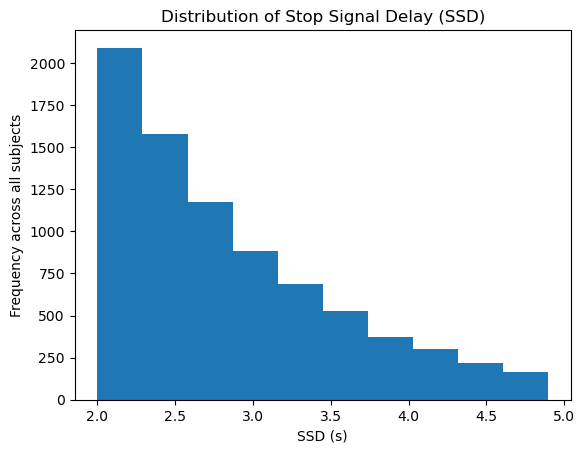

In [47]:
all_ssds = []

for subject in shared_control_metrics.keys():
    
    for block in shared_control_metrics[subject].keys():
        
        for trial in shared_control_metrics[subject][block]['trial_results'].keys():

            all_ssds.append(shared_control_metrics[subject][block]['trial_results'][trial]['stop_onset'])

plt.hist(all_ssds)
plt.xlabel('SSD (s)')
plt.ylabel('Frequency across all subjects')
plt.title('Distribution of Stop Signal Delay (SSD)')
plt.savefig('figures/SSD_hist')
plt.show()

## Find the accuracies at intervals by quarters of the experiment

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load participant tracking
participant_tracking = pd.read_csv('/Users/kritiaxh/Documents/PoldrackLab/SharedControl/data/participant_tracking.csv')
non_ai_first_subs = participant_tracking[participant_tracking["Cond Order"] == 1]["Subject"].to_list()
ai_first_subs = participant_tracking[participant_tracking["Cond Order"] == 2]["Subject"].to_list()

def accuracies_at_intervals_at_quarters(quarter):
    """
    Process accuracies at intervals for a given quarter, associated with two blocks 
    of trials ('non_ai' and 'ai') based on the subject's condition order.

    Parameters:
    - quarter (int): The quarter number to process (1 to 4).

    Outputs:
    - A CSV file of accuracies for the specified quarter.
    - A plot showing the average accuracies across intervals for that quarter.
    """
    accuracies_dict = {}
    max_length = 0  # For padding trials with NaN
    
    for subject in shared_control_metrics.keys():
        trials_list = []

        # Collect trials from the relevant blocks
        if subject in non_ai_first_subs:
            # Non-AI first
            non_ai_trials = list(shared_control_metrics[subject]['non_ai']['trial_results'].keys())
            non_ai_accuracies = [shared_control_metrics[subject]['non_ai']['trial_results'][trial]['accuracies_at_intervals_until_stop_onset'] for trial in non_ai_trials]
            
            ai_trials = list(shared_control_metrics[subject]['ai']['trial_results'].keys())
            ai_accuracies = [shared_control_metrics[subject]['ai']['trial_results'][trial]['accuracies_at_intervals_until_stop_onset'] for trial in ai_trials]
            
            if quarter == 1:
                trials_list = non_ai_accuracies[:50]  # First 50 non-AI trials
            elif quarter == 2:
                trials_list = non_ai_accuracies[50:100]  # Next 50 non-AI trials
            elif quarter == 3:
                trials_list = ai_accuracies[:50]  # First 50 AI trials
            elif quarter == 4:
                trials_list = ai_accuracies[50:100]  # Next 50 AI trials
            
        elif subject in ai_first_subs:
            # AI first
            ai_trials = list(shared_control_metrics[subject]['ai']['trial_results'].keys())
            ai_accuracies = [shared_control_metrics[subject]['ai']['trial_results'][trial]['accuracies_at_intervals_until_stop_onset'] for trial in ai_trials]
            
            non_ai_trials = list(shared_control_metrics[subject]['non_ai']['trial_results'].keys())
            non_ai_accuracies = [shared_control_metrics[subject]['non_ai']['trial_results'][trial]['accuracies_at_intervals_until_stop_onset'] for trial in non_ai_trials]
            
            if quarter == 1:
                trials_list = ai_accuracies[:50]  # First 50 AI trials
            elif quarter == 2:
                trials_list = ai_accuracies[50:100]  # Next 50 AI trials
            elif quarter == 3:
                trials_list = non_ai_accuracies[:50]  # First 50 non-AI trials
            elif quarter == 4:
                trials_list = non_ai_accuracies[50:100]  # Next 50 non-AI trials

        # Ensure we are working with accuracies
        if trials_list:
            # Pad the accuracies list with NaN to ensure uniform length for averaging
            max_length = max(max_length, max(len(lst) for lst in trials_list))
            padded_trials = [np.pad(np.array(lst, dtype=float), (0, max_length - len(lst)), constant_values=np.nan) for lst in trials_list]
            accuracies_dict[subject] = np.nanmean(np.vstack(padded_trials), axis=0)

    # Prepare DataFrame
    time_intervals = [f"{i * 100}-{(i + 1) * 100}ms" for i in range(max_length)]
    df = pd.DataFrame.from_dict(accuracies_dict, orient='index')
    df = df.dropna(axis=1, how='all')  # Remove all NaN columns
    df.columns = time_intervals
    df.index.name = 'subject'
    df = df.sort_values(by='subject')
    
    df['cond_order'] = df.index.map(lambda x: 1 if x in non_ai_first_subs else 2)  # 1 for non_ai_first, 2 for ai_first
    df.loc['mean across all subjects'] = df.mean()
    df.to_csv(f"output/shared_control_metrics_accuracies_until_stop_onset_at_intervals_quarter_{quarter}.csv")

    # Plotting without the 'cond_order' column
    df_plot = df.drop(columns=['cond_order'], errors='ignore')  # Remove 'cond_order' before plotting
    plt.figure(figsize=(12, 6))
    plt.plot(df_plot.loc['mean across all subjects'], marker = 'o')
    plt.title(f'Average Accuracies Across Intervals in Quarter {quarter}')
    plt.xlabel('Time Intervals (ms)')
    plt.ylabel('Mean Accuracy')
    plt.xticks(rotation=90)
    plt.ylim(0.7, 1.01)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'figures/accuracies_until_stop_onset_at_intervals_quarter_{quarter}.png', dpi=300)
    plt.close()

# Run for each quarter
accuracies_at_intervals_at_quarters(1)
accuracies_at_intervals_at_quarters(2)
accuracies_at_intervals_at_quarters(3)
accuracies_at_intervals_at_quarters(4)

/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_28395/612038193.py:68: RuntimeWarning: Mean of empty slice
  accuracies_dict[subject] = np.nanmean(np.vstack(padded_trials), axis=0)
/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_28395/612038193.py:68: RuntimeWarning: Mean of empty slice
  accuracies_dict[subject] = np.nanmean(np.vstack(padded_trials), axis=0)
/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_28395/612038193.py:68: RuntimeWarning: Mean of empty slice
  accuracies_dict[subject] = np.nanmean(np.vstack(padded_trials), axis=0)
/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_28395/612038193.py:68: RuntimeWarning: Mean of empty slice
  accuracies_dict[subject] = np.nanmean(np.vstack(padded_trials), axis=0)


## Create CSVs of SSRT by each half of trials in a block 

In [49]:
def grab_mean_metric_by_halves(measure):
    """
    Function to find the mean of a specified metric across different trial conditions 
    for each subject, split by halves of trials.

    Parameters:
    - measure (str): The name of the measure to calculate the mean for.

    Outputs:
    - Saves two CSV files with means for each subject across non_ai trials and ai condition trials
      split by halves.
    """
    # Initialize structures for data collection
    condition_measure_first_half = {}
    condition_measure_second_half = {}

    for subject in shared_control_metrics.keys():
        non_ai_condition_stop_trials_first_half = []
        non_ai_condition_stop_trials_second_half = []
        ai_condition_stop_trials_first_half = []
        ai_condition_ai_trials_first_half = []
        ai_condition_stop_trials_second_half = []
        ai_condition_ai_trials_second_half = []
        
        for block in shared_control_metrics[subject].keys():
            # Get the trial results for the current subject and block
            trial_results = shared_control_metrics[subject][block]['trial_results']
            num_trials = len(trial_results)

            for index, trial in enumerate(trial_results.keys()):
                if subject in exclusions.keys() and trial in exclusions[subject] and block in exclusions[subject]:
                    continue
                
                ssrt_value = shared_control_metrics[subject][block]['trial_results'][trial][measure]
                
                if pd.isna(ssrt_value):
                    continue
                
                if block == 'non_ai':
                    if index < num_trials / 2:  # First half
                        non_ai_condition_stop_trials_first_half.append(ssrt_value)
                    else:  # Second half
                        non_ai_condition_stop_trials_second_half.append(ssrt_value)
                    
                elif block == 'ai':
                    condition = shared_control_metrics[subject][block]['trial_results'][trial]['condition']
                    if condition == 'stop':
                        if index < num_trials / 2:  # First half
                            ai_condition_stop_trials_first_half.append(ssrt_value)
                        else:  # Second half
                            ai_condition_stop_trials_second_half.append(ssrt_value)
                    elif condition == 'ai':
                        if index < num_trials / 2:  # First half
                            ai_condition_ai_trials_first_half.append(ssrt_value)
                        else:  # Second half
                            ai_condition_ai_trials_second_half.append(ssrt_value)
                            
        # Store the results for the first half
        condition_measure_first_half[subject] = {
            'non_ai_ssrt_first_half': np.nanmean(non_ai_condition_stop_trials_first_half),
            'ai_ssrt_first_half': np.nanmean(ai_condition_stop_trials_first_half),
            'ai_ai_ssrt_first_half': np.nanmean(ai_condition_ai_trials_first_half)
        }
        
        # Store the results for the second half
        condition_measure_second_half[subject] = {
            'non_ai_ssrt_second_half': np.nanmean(non_ai_condition_stop_trials_second_half),
            'ai_ssrt_second_half': np.nanmean(ai_condition_stop_trials_second_half),
            'ai_ai_ssrt_second_half': np.nanmean(ai_condition_ai_trials_second_half)
        }
    
    # Create DataFrames from the dictionaries
    df_first_half = pd.DataFrame(condition_measure_first_half).T
    df_second_half = pd.DataFrame(condition_measure_second_half).T

    df_first_half = df_first_half.sort_index()
    df_first_half.loc['mean'] = df_first_half.mean()

    df_second_half = df_second_half.sort_index()
    df_second_half.loc['mean'] = df_second_half.mean()
    
    # Save to CSV files
    df_first_half.to_csv('output/shared_control_ssrt_first_half.csv')
    df_second_half.to_csv('output/shared_control_ssrt_second_half.csv')
    
    return df_first_half, df_second_half

In [50]:
grab_mean_metric_by_halves('ssrt')

(      non_ai_ssrt_first_half  ai_ssrt_first_half  ai_ai_ssrt_first_half
 s004                0.223061            0.227631               0.242736
 s005                0.203335            0.237387               0.278161
 s006                0.250920            0.251013               0.268314
 s007                0.267348            0.281318               0.300084
 s008                0.239715            0.248039               0.275791
 s009                0.217364            0.248468               0.231708
 s010                0.247669            0.232707               0.249885
 s011                0.207663            0.244987               0.245212
 s012                0.209752            0.248900               0.227008
 s013                0.249410            0.252739               0.353516
 s014                0.223944            0.222889               0.249608
 s015                0.277031            0.494835               0.334678
 s016                0.318979            0.241767  

## Displaying Trials for QC

In [51]:
import matplotlib.pyplot as plt
import itertools
from matplotlib.ticker import MultipleLocator

In [52]:
def plot_trial_pressure_individual(trial_data, trial_number, ax, color):
    """
    Function to plot the pressure data for an individual trial. It includes vertical 
    lines marking key events such as stop onset, moment of inhibition, stop moment, 
    and post-buffer stamp.

    Parameters:
    - trial_data (dict): A dictionary containing trial data with keys:
    - trial_number (int): The number of the trial being plotted.
    - ax (matplotlib.axes.Axes): The axes on which to plot the data.
    - color (str): The color to use for the trial plot.
    """
    pressures_raw = trial_data['pressures_raw']
    time_stamps_raw = trial_data['time_stamps_raw']
    stop_onset_time = trial_data.get('stop_onset', None)
    moment_of_inhibition = trial_data.get('moment_of_inhibition', None)
    stop_moment = trial_data.get('stop_moment', None)
    post_buffer_stamp = trial_data.get('post_buffer_stamp', None)

    # Plotting all pressures
    ax.plot(time_stamps_raw, pressures_raw, label=f'Trial {trial_number}', color=color)

    # Adding vertical dotted lines at critical points if available
    if stop_onset_time is not None:
        ax.axvline(x=stop_onset_time, color='black', linestyle='dotted', linewidth=2, label='Stop Onset')
    if moment_of_inhibition is not None:
        ax.axvline(x=moment_of_inhibition, color='green', linestyle='dotted', linewidth=2, label='Moment of Inhibition')
    if stop_moment is not None:
        ax.axvline(x=stop_moment, color='red', linestyle='dotted', linewidth=2, label='Stop Moment')
    if post_buffer_stamp is not None:
        ax.axvline(x=post_buffer_stamp, color='purple', linestyle='dotted', linewidth=2, label='Post Buffer Stamp')

    # Setting axis labels, title, and grid
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Raw Pressure')
    ax.set_title(f'Trial {trial_number}')
    ax.legend()
    ax.grid(True)

    # Set fixed y-axis and x-axis limits
    ax.set_ylim(-0.05, 1.1)
    ax.set_xlim(0, 6.3)  # Set x-axis limits from 0 to 6 seconds

    # Set x-axis major and minor ticks
    ax.xaxis.set_major_locator(MultipleLocator(1))  # Major ticks at every second
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))  # Minor ticks at every 100 ms

In [53]:
def display_subject_trials(subject, block, data = shared_control_metrics):
    """
    Function to plot the individual trial pressures for a specified subject and block. 
    The trials are displayed in a grid format, with AI trials shown in blue and stop trials in red.

    Parameters:
    - subject (str): The identifier for the subject whose trials are to be displayed.
    - block (str): The block type (e.g., 'ai', 'non_ai') of the trials to display.
    - data (dict): The dataset containing all trial information, defaults to shared_control_metrics.
    """
    
    # plotting individual AI block trials
    num_trials_ai = len(data[subject][block]['trial_results'])
    num_cols = 2
    num_rows = (num_trials_ai + 1) // 2  # Add 1 to round up

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), squeeze=False)  # Ensure axs is always a 2D array
    
    # notes. if its an AI trial the trial will be blue, if its a stop then red
    ai_color = 'blue'
    stop_color = 'red'

    for i, (trial_number, trial_data) in enumerate(data[subject][block]['trial_results'].items()):
        row = i // num_cols
        col = i % num_cols
        condition = trial_data['condition']
        color = ai_color if condition == 'ai' else stop_color
        plot_trial_pressure_individual(trial_data, trial_number, axs[row, col], color=color)


    plt.tight_layout()
    plt.show()

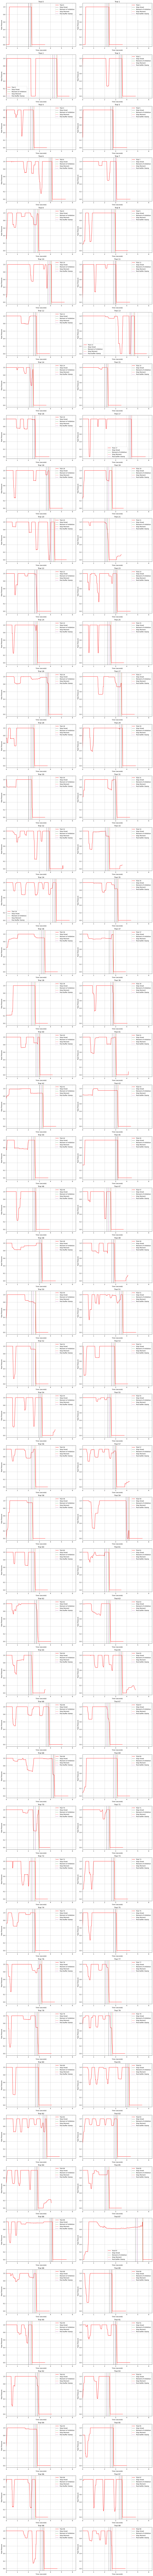

In [54]:
subject = 's027'
condition = 'non_ai'

display_subject_trials(subject, condition, data = shared_control_metrics)

## Plot distributions for individual trial estimates

In [67]:
def plot_distributions(measure):
    """
    Function to plot histograms for individual trial estimates of SSRT and duration of inhibition 
    across non_ai stop, ai stop, and ai ai conditions for each subject.
    Saves all the plots together in one large image file.
    
    Parameters:
    - measure (str): The measure to plot (e.g., 'SSRT', 'duration_of_inhibition').
    """

    # Sort the subjects in ascending order
    sorted_subjects = sorted(shared_control_metrics.keys(), key=lambda x: int(x[1:]))
    
    num_subjects = len(sorted_subjects)
    
    # Set up the figure size (adjust depending on how many subjects you have)
    fig, axes = plt.subplots(num_subjects, 3, figsize=(15, num_subjects * 3))
    
    # Loop through all subjects
    for i, subject in enumerate(sorted_subjects):
        
        non_ai_condition_stop_trials = []
        ai_condition_stop_trials = []
        ai_condition_ai_trials = []

        # Loop through the blocks and extract data for histograms
        for block in shared_control_metrics[subject].keys():
            for trial in shared_control_metrics[subject][block]['trial_results'].keys():

                if subject in exclusions.keys() and trial in exclusions[subject] and block in exclusions[subject]:
                    continue
                
                # Collect data for the respective conditions
                if block == 'non_ai':
                    non_ai_condition_stop_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])
                    
                elif (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'stop'):
                    ai_condition_stop_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])
                    
                elif (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'ai'):
                    ai_condition_ai_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])

        # Combine all trial data to get consistent axes
        all_trials = non_ai_condition_stop_trials + ai_condition_stop_trials + ai_condition_ai_trials
        if len(all_trials) > 0:
            x_min = min(all_trials)
            x_max = max(all_trials)

            # Plot histograms for each condition in subplots
            sns.histplot(non_ai_condition_stop_trials, kde=True, ax=axes[i, 0], binwidth=0.009, edgecolor='black')
            axes[i, 0].set_title(f"Non-AI Stop Trials (Sub {subject})")
            axes[i, 0].set_xlabel(f"{measure} (s)")
            axes[i, 0].set_ylabel("Frequency")
            axes[i, 0].set_xlim(x_min, x_max)

            # Calculate and display the mean RT for Non-AI Stop Trials
            mean_non_ai = np.nanmean(non_ai_condition_stop_trials)
            axes[i, 0].text(0.95, 0.95, f'Mean: {mean_non_ai}', 
                            transform=axes[i, 0].transAxes, fontsize=10, 
                            verticalalignment='top', horizontalalignment='right')
            
            sns.histplot(ai_condition_stop_trials, kde=True, ax=axes[i, 1], binwidth=0.009, edgecolor='black')
            axes[i, 1].set_title(f"AI Stop Trials (Sub {subject})")
            axes[i, 1].set_xlabel(f"{measure} (s)")
            axes[i, 1].set_ylabel("Frequency")
            axes[i, 1].set_xlim(x_min, x_max)

            # Calculate and display the mean RT for AI Stop Trials
            mean_ai = np.nanmean(ai_condition_stop_trials)
            # sd_ai = np.std(ai_condition_stop_trials)
            axes[i, 1].text(0.95, 0.95, f'Mean: {mean_ai}',
                            transform=axes[i, 1].transAxes, fontsize=10, 
                            verticalalignment='top', horizontalalignment='right')
            # axes[i, 1].text(0.85, 0.85, f'SD: {sd_ai}',
            #                 transform=axes[i, 1].transAxes, fontsize=10, 
            #                 verticalalignment='top', horizontalalignment='right')
            
            sns.histplot(ai_condition_ai_trials, kde=True, ax=axes[i, 2], binwidth=0.009, edgecolor='black')
            axes[i, 2].set_title(f"AI AI Trials (Sub {subject})")
            axes[i, 2].set_xlabel(f"{measure} (s)")
            axes[i, 2].set_ylabel("Frequency")
            axes[i, 2].set_xlim(x_min, x_max)

            # Calculate and display the mean RT for AI AI Trials
            mean_ai_ai = np.nanmean(ai_condition_ai_trials)
            axes[i, 2].text(0.95, 0.95, f'Mean: {mean_ai_ai}', 
                            transform=axes[i, 2].transAxes, fontsize=10, 
                            verticalalignment='top', horizontalalignment='right')

    # Adjust layout and spacing
    plt.tight_layout()

    # Save the combined plot as one image
    plt.savefig(f'figures/all_{measure}_distributions.png', dpi=300)

    # Close the figure to free up memory
    plt.close()


In [56]:
# Call the function to plot ssrt
plot_distributions('ssrt')

In [68]:
plot_distributions('duration_of_inhibition')

## Plot scatterplots of SSD vs SSRT for each subject and each condition

In [58]:
def plot_scatterplots(measure_ssd='stop_onset', measure_ssrt='ssrt'):
    """
    Function to plot scatterplots of SSD versus SSRT for each subject and condition.
    
    Parameters:
    - measure_ssd (str): The key for the SSD measure. E.g., 'stop_onset'.
    - measure_ssrt (str): The key for the SSRT measure. E.g., 'ssrt'.
    """
    
    # Sort the subjects in ascending order
    sorted_subjects = sorted(shared_control_metrics.keys(), key=lambda x: int(x[1:]))
    
    num_subjects = len(sorted_subjects)
    
    # Set up the figure size (adjust depending on how many subjects you have)
    fig, axes = plt.subplots(num_subjects, 3, figsize=(15, num_subjects * 5), squeeze=False)  # Ensure axes is always 2D

    conditions = ['non_ai', 'ai', 'ai_ai']
    colors = ['teal', 'chocolate', 'darkgray']

    # Initialize a dictionary to hold correlation coefficients for each condition
    correlations = {cond: [] for cond in conditions}

    # Loop through all subjects
    for i, subject in enumerate(sorted_subjects):
        
        # Initialize lists to collect SSD and SSRT values
        ssd_values = {cond: [] for cond in conditions}
        ssrt_values = {cond: [] for cond in conditions}
        
        # Loop through the blocks and extract SSD and SSRT for each condition
        for block in shared_control_metrics[subject].keys():
            for trial in shared_control_metrics[subject][block]['trial_results'].keys():

                if subject in exclusions.keys() and trial in exclusions[subject] and block in exclusions[subject]:
                    continue
                
                # Collect SSD and SSRT for the respective conditions
                if (block == 'non_ai' and ~np.isnan(shared_control_metrics[subject][block]['trial_results'][trial][measure_ssd])
                    and ~np.isnan(shared_control_metrics[subject][block]['trial_results'][trial][measure_ssrt])):
                    ssd = shared_control_metrics[subject][block]['trial_results'][trial][measure_ssd]
                    ssrt = shared_control_metrics[subject][block]['trial_results'][trial][measure_ssrt]
                    ssd_values['non_ai'].append(ssd)
                    ssrt_values['non_ai'].append(ssrt)
                    
                elif (block == 'ai'
                    and ~np.isnan(shared_control_metrics[subject][block]['trial_results'][trial][measure_ssd])
                    and ~np.isnan(shared_control_metrics[subject][block]['trial_results'][trial][measure_ssrt])):
                    if shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'stop':
                        ssd = shared_control_metrics[subject][block]['trial_results'][trial][measure_ssd]
                        ssrt = shared_control_metrics[subject][block]['trial_results'][trial][measure_ssrt]
                        ssd_values['ai'].append(ssd)
                        ssrt_values['ai'].append(ssrt)
                        
                    elif (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'ai'
                        and ~np.isnan(shared_control_metrics[subject][block]['trial_results'][trial][measure_ssd])
                        and ~np.isnan(shared_control_metrics[subject][block]['trial_results'][trial][measure_ssrt])):
                        ssd = shared_control_metrics[subject][block]['trial_results'][trial][measure_ssd]
                        ssrt = shared_control_metrics[subject][block]['trial_results'][trial][measure_ssrt]
                        ssd_values['ai_ai'].append(ssd)
                        ssrt_values['ai_ai'].append(ssrt)

        # Create scatter plots for each condition
        for j, condition in enumerate(conditions):
            ax = axes[i, j]
            if ssd_values[condition] and ssrt_values[condition]:
                ax.scatter(ssd_values[condition], ssrt_values[condition], color=colors[j], label=condition)
                corr_coef = np.corrcoef(ssd_values[condition], ssrt_values[condition])[0, 1]
                correlations[condition].append(corr_coef)
                ax.text(0.7, 0.95, f'Corr: {corr_coef:.2f}', fontsize=12, 
                            transform=ax.transAxes, verticalalignment='top')
                ax.set_xlim(1.9, 5)
                ax.set_title(f'Subject: {subject} - Condition: {condition.title()}')
                ax.set_xlabel('Stop Signal Delay (SSD)')
                ax.set_ylabel('Stop Signal Reaction Time (SSRT)')
            else:
                ax.set_title(f'Subject: {subject} - Condition: {condition.title()}')
                ax.set_xlabel('Stop Signal Delay (SSD)')
                ax.set_ylabel('Stop Signal Reaction Time (SSRT)')
                ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()
    plt.savefig(f'figures/ssd_vs_ssrt_scatterplots.png', dpi=300)
    plt.close()

    # Calculate mean correlations for each condition
    mean_correlations = {cond: np.mean(correlations[cond]) if correlations[cond] else None for cond in conditions}
    
    # Print mean correlations
    for cond, mean_correlation in mean_correlations.items():
        if mean_correlation is not None:
            print(f'Mean Correlation for {cond}: {mean_correlation:.2f}')
        else:
            print(f'Mean Correlation for {cond}: No data')

In [59]:
plot_scatterplots('stop_onset', 'ssrt')

Mean Correlation for non_ai: -0.18
Mean Correlation for ai: -0.19
Mean Correlation for ai_ai: -0.18


## Relative speeds of the ball and ring

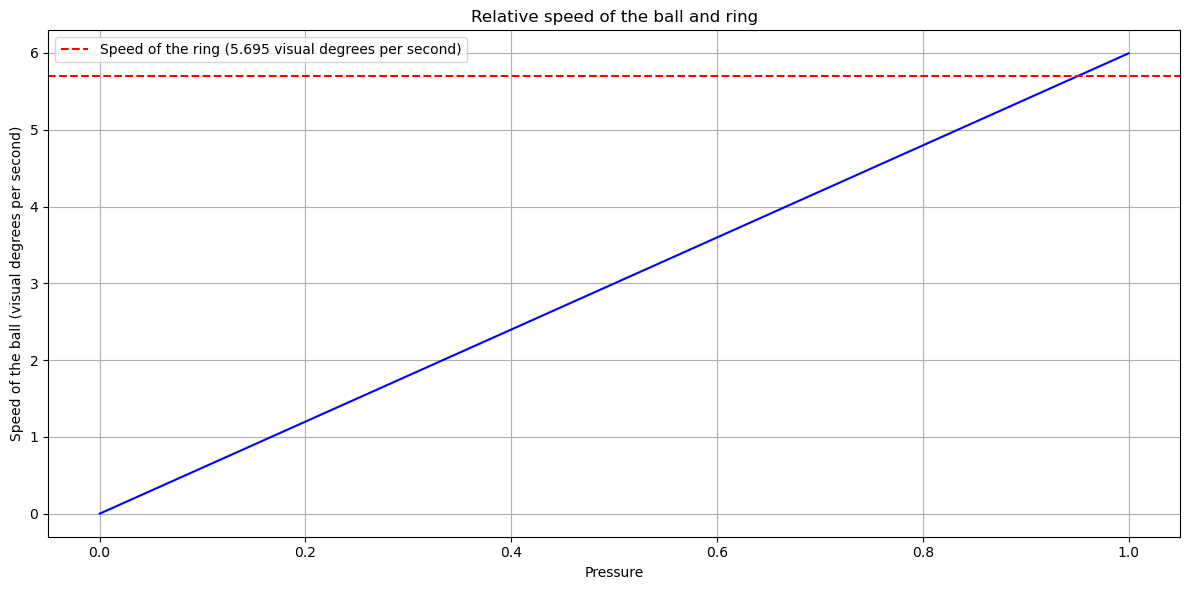

In [60]:
# Generate an array of pressure values between 0 and 1
pressures = np.linspace(0, 1, 100)  # 100 evenly spaced values between 0 and 1

# Calculate visual degrees per second
degrees_per_loop = pressures * 0.1  # Convert pressure to visual degrees per loop
loops_per_second = 1 / 0.01668  # Calculate how many loops fit into one second
visual_degrees_per_second = degrees_per_loop * loops_per_second  # Convert to degrees per second

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(pressures, visual_degrees_per_second, color='blue')
plt.title('Relative speed of the ball and ring')
plt.xlabel('Pressure')
plt.ylabel('Speed of the ball (visual degrees per second)')
plt.grid(True)

# The speed of the ring is 5.695 visual degrees/second
plt.axhline(y=05.695, color='red', linestyle='--', label='Speed of the ring (5.695 visual degrees per second)') 

# Display legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig('figures/relative_speed_of_ball_and_ring')
plt.show()

In [61]:
import subprocess
import re

# Run pip freeze and capture output
result = subprocess.run(['pip', 'freeze'], capture_output=True, text=True)

# Use a regex to remove lines that include 'file:///'
cleaned_output = re.sub(r' @ file://[^\n]+', '', result.stdout)

# Write the cleaned output to a new requirements.txt file
with open('requirements.txt', 'w') as f:
    f.write(cleaned_output)

print("Cleaned requirements.txt has been generated.")

Cleaned requirements.txt has been generated.
